In [40]:
import torch
import numpy as np
from matplotlib import pyplot as plt

from safety_model.utils import multi_repeat

In [4]:
env_type = "Feeding"
test_parquet_path = "./parquet_datasets/feeding_250_test.parquet"

from voraus_ad_dataset.assistive_ad import ANOMALY_CATEGORIES, get_signals, get_env_params, load_torch_dataloaders
state_size, action_size = get_env_params(env_type)
Signals = get_signals(state_size, action_size)
_, test_dataset, _, test_dataloader = load_torch_dataloaders(
    train_dataset=test_parquet_path,  # hack
    test_dataset=test_parquet_path,
    batch_size=1,
    columns=Signals.state() + Signals.action(),
    seed=42,
    frequency_divider=1.0,
    train_gain=1.0,
    normalize=False,
    pad=False,
    env_type=env_type,
)

loading data took 0.128 seconds
extract train dfs and labels took 0.177 seconds
extract test dfs and labels took 0.145 seconds
update meta data took 0.000 seconds


In [5]:
episode, meta = test_dataset[5]
episode, meta

(tensor([[ 2.7636e-01,  2.0193e-01,  7.6492e-01,  ..., -8.0735e-03,
          -1.3269e-02,  1.2748e-04],
         [ 2.7649e-01,  2.0139e-01,  7.6497e-01,  ...,  6.8791e-03,
           1.1224e-02,  1.1200e-02],
         [ 2.7670e-01,  2.0073e-01,  7.6512e-01,  ...,  2.5477e-02,
           2.2188e-02,  2.3411e-03],
         ...,
         [-2.9082e-01,  2.7753e-01,  8.1243e-01,  ...,  5.0046e-02,
           1.2555e-01,  3.7176e-02],
         [-2.9167e-01,  2.7717e-01,  8.1309e-01,  ...,  4.4902e-02,
           2.0755e-01,  6.0039e-02],
         [-2.9404e-01,  2.7619e-01,  8.1369e-01,  ..., -2.9680e-03,
           2.1145e-01, -6.3772e-02]]),
 {'sample': 5, 'anomaly': True, 'category': 'FAILURE', 'variant': 'ANOMALY'})

In [6]:
max_episode_length = 200
epi_len = 150


In [35]:
def run_over_episode(sm, episode, epi_len):
    if sm.in_horizon > 0:
        tensor_padded = torch.zeros((max_episode_length, episode.shape[1]))
        tensor_padded[:epi_len] = episode[:epi_len]
        tensor = tensor_padded
    else:
        tensor = episode[epi_len - sm.in_horizon: epi_len] 
    
    with torch.inference_mode():
        batch = {'obs': tensor[None, ..., :state_size], 'action': tensor[None, ..., state_size:], 'length': torch.tensor([[epi_len]])}
        multibatch = multi_repeat(batch, sm.ensemble_size)
        input_act, input_obs, input_length = sm.preprocess(multibatch)
        
        if sm.normalizer:
            input_obs = sm.normalizer['obs'].normalize(input_obs)
            input_act = sm.normalizer['action'].normalize(input_act)
        
        obs_act = {
            'action': input_act,     # [Ensemble, Batch, Time, ActDim]
            'obs': input_obs,        # [Ensemble, Batch, Time, ObsDim]
            'length': input_length,  # [Ensemble, Batch]
        }
        
        obs_act_recon, z_mu, z_logvar, z, z_all = sm.forward(obs_act, ensemble_sampling=False, normalize=False)
        obs_act = torch.cat([obs_act['obs'], obs_act['action']], axis=-1)
        recon_losses = torch.pow(obs_act_recon - obs_act, 2)[0, 0].mean(dim=(-1))
        return recon_losses.numpy()

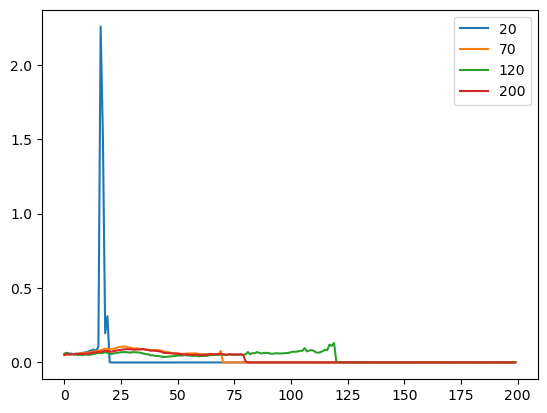

In [33]:
sm = torch.load("test_vae_incvar_full.pth").to("cpu")
for epi_len in range(20, 150, 50):
    plt.plot(run_over_episode(sm, episode, epi_len=epi_len), label=f"{epi_len}")
plt.plot(run_over_episode(sm, episode, epi_len=80), label=f"{200}")
plt.legend()

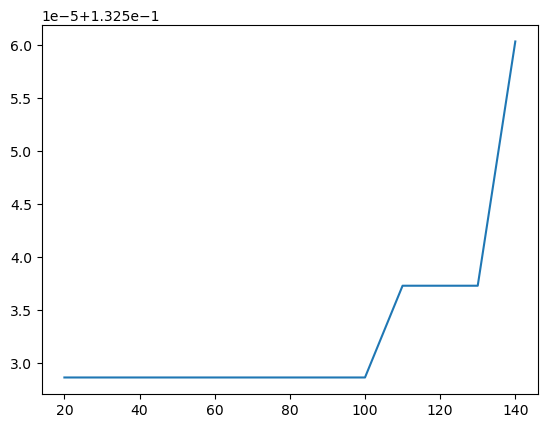

In [42]:
sm = torch.load("test2.pth").to("cpu")
recon_losses = []
epi_lens = list(range(20, 150, 10))
for epi_len in epi_lens:
    score = run_over_episode(sm, episode, epi_len=epi_len).mean()
    recon_losses.append(max(np.max(recon_losses + [-np.inf]), score))
plt.plot(epi_lens, recon_losses)